# 加载数据

In [1]:
# 文件保存位置
file_path = '/root/autodl-tmp/fam_classifier/cola/'

In [2]:
from datasets import load_dataset
from transformers import BertTokenizer
import torch
from d2l import torch as d2l


# 使用 BERT 的分词器对文本语句进行分词
dataset = load_dataset('glue', name='cola')
tokenizer = BertTokenizer.from_pretrained('bert-base-cased',
                                         add_special_tokens=True)

Reusing dataset glue (/root/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
class ColaDataset(torch.utils.data.Dataset):
    """用于加载cola数据集"""

    def __init__(self, dataset, num_steps, tokenizer, vocab=None):
        self.num_steps = num_steps
        self.tokens = [tokenizer.tokenize(sen) for sen in dataset['sentence']]
        maxlen = max([len(tokens) for tokens in self.tokens])
        print(f'Max length of token sequence: {maxlen}')
        self.labels = torch.tensor(dataset['label'])
        if vocab is None:
            self.vocab = d2l.Vocab(self.tokens,
                                   reserved_tokens=['<pad>', '<cls>'])
        else:
            self.vocab = vocab
        out = list(map(self._preprocess, self.tokens))
        all_token_ids = [token_ids for token_ids, _ in out]
        all_valid_lens = [valid_lens for _, valid_lens in out]
        self.all_token_ids = torch.tensor(all_token_ids, dtype=torch.long)
        self.all_valid_lens = torch.tensor(all_valid_lens)
        print('read ' + str(len(self.all_token_ids)) + ' examples')

    def _preprocess(self, tokens):
        self._truncate_tokens(tokens)
        tokens = ['<cls>'] + tokens
        token_ids = self.vocab[tokens] + [self.vocab['<pad>']] \
                    * (self.num_steps - len(tokens))
        valid_lens = len(tokens)
        return token_ids, valid_lens

    def _truncate_tokens(self, tokens):
        # 为"<cls>标签预留位置"
        while len(tokens) > self.num_steps - 1:
            tokens.pop()

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], 
                self.all_valid_lens[idx]), self.labels[idx]

    def __len__(self):
        return len(self.all_token_ids)

In [9]:
num_steps, batch_size = 50, 16
train_set = ColaDataset(dataset['train'], num_steps, tokenizer)
vocab = train_set.vocab
print(f'词表大小: {len(vocab)}') 
valid_set = ColaDataset(dataset['validation'], num_steps, tokenizer, vocab)

Max length of token sequence: 45
read 8551 examples
词表大小: 5956
Max length of token sequence: 34
read 1043 examples


In [7]:
# 查看数据文本的 token list
train_set.tokens[1000]

['I', 'read', 'three', 'his', 'books', '.']

In [10]:
train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)
# test_iter = torch.utils.data.DataLoader(test_set, batch_size)
valid_iter = torch.utils.data.DataLoader(valid_set, batch_size)
print(f'训练集长度: {len(train_iter)}, '
      f'验证集长度: {len(valid_iter)}')

训练集长度: 535, 验证集长度: 66


# 训练词向量

In [15]:
from gensim.models import word2vec


model = word2vec.Word2Vec(sentences=train_set.tokens, vector_size=512, sg=1, min_count=1)
print(f'词向量模型中保存的单词数量为 {len(model.wv.index_to_key)}')
model.save(file_path + "cola_word_vec_sg_min1.bin")

词向量模型中保存的单词数量为 5953


# 因子分析

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
# from gensim.models import word2vec
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity,calculate_kmo

In [18]:
# 加载 word2vector 模型
model = word2vec.Word2Vec.load(file_path + 'cola_word_vec_sg_min1.bin')

In [16]:
embedding = np.array([model.wv[word] for word in model.wv.index_to_key])
print(f"词向量矩阵尺寸: {embedding.shape}")
# 查看某个单词的词向量
print("单词film, 索引:  ", model.wv.key_to_index['film'], "向量: ", model.wv['film'])

词向量矩阵尺寸: (5953, 512)
单词film:  3670 [ 0.00067321 -0.0147386   0.01622277  0.04943561  0.06070393  0.02208116
 -0.00306527 -0.01757154  0.02561275  0.01819989  0.05919463  0.03114606
  0.02818074 -0.04726499  0.00901544 -0.0045493   0.02536115  0.03498453
 -0.02030631 -0.02280748  0.02798464 -0.04969786  0.02932375 -0.02342127
 -0.06469516  0.01508706  0.03071228 -0.0065481   0.00787455 -0.01343325
  0.02272628  0.0220133  -0.00659877 -0.00936674 -0.03594262  0.01846363
  0.02223285  0.02582609 -0.06801753 -0.02156065 -0.02286487  0.03227818
 -0.05380051 -0.02047102  0.08602271  0.04159933  0.039427   -0.02488046
 -0.01926424 -0.0219202   0.01013623  0.00044712  0.02644728 -0.00063266
 -0.06377125  0.0087523  -0.00369908 -0.05664607 -0.02418485 -0.01833108
  0.0475396   0.05355097  0.0276797   0.01978247  0.0158341  -0.0009738
 -0.05746465 -0.02795283  0.00018604 -0.05228028  0.02786082 -0.03280906
 -0.07541947 -0.01891064 -0.02125478  0.04491287  0.03285615  0.01611457
 -0.01315588  0.0

In [19]:
# Bartlett's球状检验
print('Bartlett\'s球状检验: 检验总体变量的相关矩阵是否是单位阵')
chi_square_value, p_value = calculate_bartlett_sphericity(embedding)
print(chi_square_value, p_value)

# 导入kmo检验
print('kmo检验:')
print('检查变量间的相关性和偏相关性，取值在0-1之间；KMO统计量越接近1，变量间的相关性越强，偏相关性越弱，因子分析的效果越好')
kmo_all, kmo_model = calculate_kmo(embedding)
print('KMO值为: ', kmo_model)

Bartlett's球状检验: 检验总体变量的相关矩阵是否是单位阵
inf 0.0
kmo检验:
检查变量间的相关性和偏相关性，取值在0-1之间；KMO统计量越接近1，变量间的相关性越强，偏相关性越弱，因子分析的效果越好
KMO值为:  0.9991196744780876


/root/miniconda3/lib/python3.8/site-packages/factor_analyzer/factor_analyzer.py:108: RuntimeWarning: divide by zero encountered in log
  statistic = -np.log(corr_det) * (n - 1 - (2 * p + 5) / 6)
/root/miniconda3/lib/python3.8/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


In [20]:
print('******开始因子分析******')
fa = FactorAnalyzer(25, rotation='varimax')
fa.fit(embedding)

# 特征值、特征向量
ev, v = fa.get_eigenvalues()

******开始因子分析******


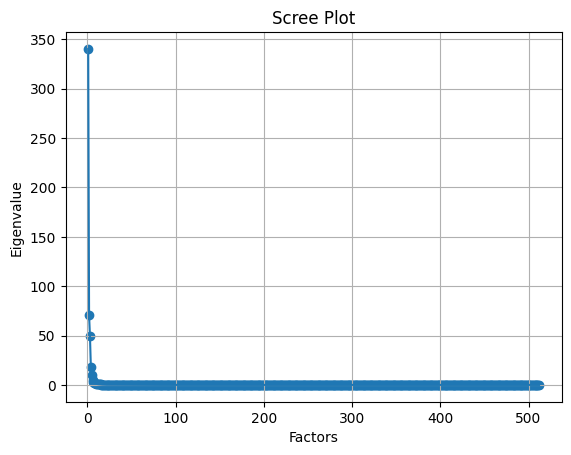

In [21]:
# 可视化, plot横轴是指标个数，纵轴是ev值
plt.scatter(range(1, embedding.shape[1]+1), ev)
plt.plot(range(1, embedding.shape[1]+1), ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()
# plt.savefig('ev.png')

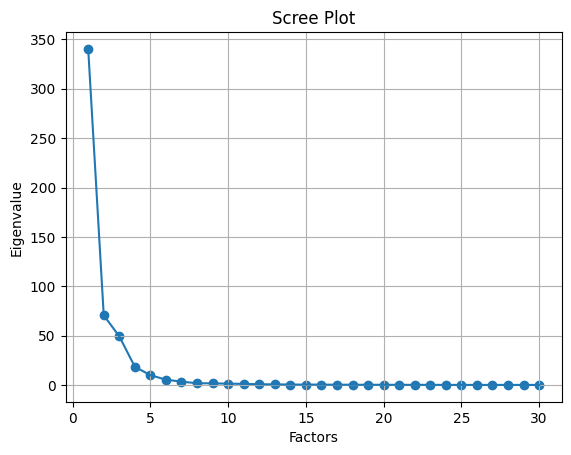

In [22]:
# 前三十
plt.scatter(range(1, 31), ev[:30])
plt.plot(range(1, 31), ev[:30])
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()
# plt.savefig(file_path + 'ev30.png')

In [23]:
fa = FactorAnalyzer(8, rotation="promax")
fa.fit(embedding)
print("因子分析结果矩阵: ", fa.loadings_.shape)

# 512*8(变量个数*因子个数)
index = fa.loadings_.argmax(axis=1)
res = np.array([[i, idx] for i, idx in enumerate(index)])

data_1 = pd.DataFrame(fa.loadings_, columns=['fa1', 'fa2', 'fa3', 'fa4', 'fa5', 'fa6', 'fa7', 'fa8'])
data_2 = pd.DataFrame(res, columns=['Dimension', 'Factor'])
with pd.ExcelWriter(file_path + "colaFA.xlsx") as writer1:
    data_1.to_excel(writer1, sheet_name="Sheet1")
    data_2.to_excel(writer1, sheet_name="Sheet2")
    writer1.save()

因子分析结果矩阵:  (512, 8)


Text(120.72222222222221, 0.5, 'Dimension')

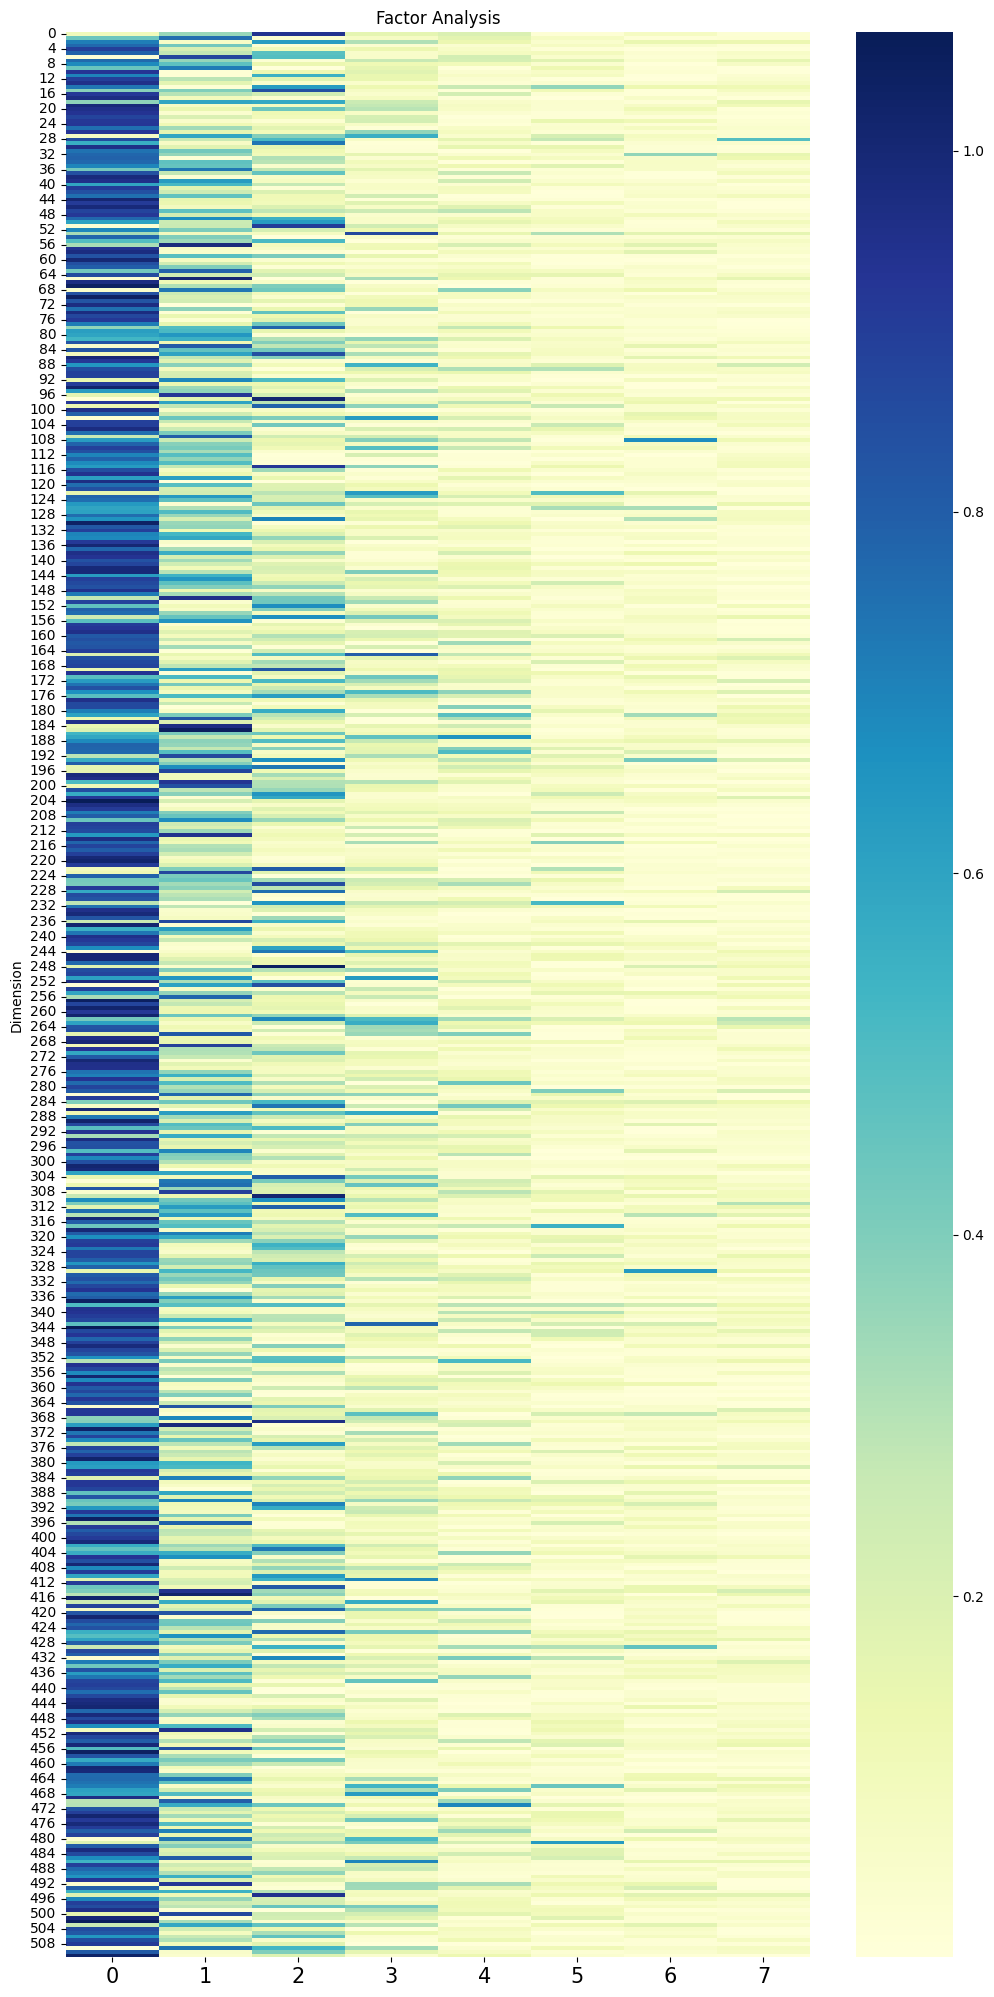

In [24]:
# 因子分析结果可视化
df_cm = pd.DataFrame(np.abs(fa.loadings_))
fig, ax = plt.subplots(figsize=(12, 25))
sns.heatmap(df_cm, annot=None, cmap='YlGnBu', ax=ax)  # cbar_kws

ax.tick_params(axis='x', labelsize=15)
ax.set_title("Factor Analysis", fontsize=12)
ax.set_ylabel("Dimension")

In [25]:
# 保存可视化结果图
plt.savefig(file_path + 'cola_dimension.png')

<Figure size 640x480 with 0 Axes>

# 模型架构

## FAM

In [11]:
import torch
from torch import nn
import numpy as np
import pandas as pd
from d2l import torch as d2l
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import math
from gensim.models import word2vec

In [12]:
class FamAttention(nn.Module):
    """修改多头注意力，针对嵌入512维，8个head的模型"""
    def __init__(self, num_hiddens, dim_dict, dropout, bias=False, **kwargs):
        super(FamAttention, self).__init__(**kwargs)
        self.attention = d2l.DotProductAttention(dropout)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)
        self.dim_dict = dim_dict
        self.dim_0 = [dim for dim, idx in self.dim_dict.items() if idx == 0]
        self.dim_1 = [dim for dim, idx in self.dim_dict.items() if idx == 1]
        self.dim_2 = [dim for dim, idx in self.dim_dict.items() if idx == 2]
        self.dim_3 = [dim for dim, idx in self.dim_dict.items() if idx == 3]
        self.dim_4 = [dim for dim, idx in self.dim_dict.items() if idx == 4]
        self.dim_5 = [dim for dim, idx in self.dim_dict.items() if idx == 5]
        self.dim_6 = [dim for dim, idx in self.dim_dict.items() if idx == 6]
        self.dim_7 = [dim for dim, idx in self.dim_dict.items() if idx == 7]
        # self.list_concat = torch.cat((self.dim_0, self.dim_1, self.dim_2, self.dim_3, self.dim_4, self.dim_5,
        # self.dim_6, self.dim_7))
        self.len_0, self.len_1, self.len_2, self.len_3, self.len_4, self.len_5, self.len_6, self.len_7 = len(
            self.dim_0), len(self.dim_1), len(self.dim_2), len(self.dim_3), len(self.dim_4), len(self.dim_5),\
            len(self.dim_6), len(self.dim_7)

        self.Wq0 = nn.Linear(self.len_0, self.len_0, bias=bias)
        self.Wq1 = nn.Linear(self.len_1, self.len_1, bias=bias)
        self.Wq2 = nn.Linear(self.len_2, self.len_2, bias=bias)
        self.Wq3 = nn.Linear(self.len_3, self.len_3, bias=bias)
        self.Wq4 = nn.Linear(self.len_4, self.len_4, bias=bias)
        self.Wq5 = nn.Linear(self.len_5, self.len_5, bias=bias)
        self.Wq6 = nn.Linear(self.len_6, self.len_6, bias=bias)
        self.Wq7 = nn.Linear(self.len_7, self.len_7, bias=bias)

        self.Wk0 = nn.Linear(self.len_0, self.len_0, bias=bias)
        self.Wk1 = nn.Linear(self.len_1, self.len_1, bias=bias)
        self.Wk2 = nn.Linear(self.len_2, self.len_2, bias=bias)
        self.Wk3 = nn.Linear(self.len_3, self.len_3, bias=bias)
        self.Wk4 = nn.Linear(self.len_4, self.len_4, bias=bias)
        self.Wk5 = nn.Linear(self.len_5, self.len_5, bias=bias)
        self.Wk6 = nn.Linear(self.len_6, self.len_6, bias=bias)
        self.Wk7 = nn.Linear(self.len_7, self.len_7, bias=bias)

        self.Wv0 = nn.Linear(self.len_0, self.len_0, bias=bias)
        self.Wv1 = nn.Linear(self.len_1, self.len_1, bias=bias)
        self.Wv2 = nn.Linear(self.len_2, self.len_2, bias=bias)
        self.Wv3 = nn.Linear(self.len_3, self.len_3, bias=bias)
        self.Wv4 = nn.Linear(self.len_4, self.len_4, bias=bias)
        self.Wv5 = nn.Linear(self.len_5, self.len_5, bias=bias)
        self.Wv6 = nn.Linear(self.len_6, self.len_6, bias=bias)
        self.Wv7 = nn.Linear(self.len_7, self.len_7, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        def assemble(output_concat, list_concat):
            reslist = []
            for i in range(512):
                reslist.append(list_concat.index(i))
            return torch.index_select(output_concat, -1, torch.tensor(reslist, device=output_concat.device))

        # queries, keys, values的形状: (batch_size，查询或者“键－值”对的个数，num_hiddens)
        # qi, ki, vi的形状：(batch_size, 查询或者“键－值”对的个数， self.len_i)
        q0, k0, v0 = torch.index_select(queries, -1, torch.tensor(self.dim_0, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_0, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_0, device=values.device))
        q1, k1, v1 = torch.index_select(queries, -1, torch.tensor(self.dim_1, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_1, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_1, device=values.device))
        q2, k2, v2 = torch.index_select(queries, -1, torch.tensor(self.dim_2, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_2, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_2, device=values.device))
        q3, k3, v3 = torch.index_select(queries, -1, torch.tensor(self.dim_3, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_3, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_3, device=values.device))
        q4, k4, v4 = torch.index_select(queries, -1, torch.tensor(self.dim_4, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_4, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_4, device=values.device))
        q5, k5, v5 = torch.index_select(queries, -1, torch.tensor(self.dim_5, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_5, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_5, device=values.device))
        q6, k6, v6 = torch.index_select(queries, -1, torch.tensor(self.dim_6, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_6, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_6, device=values.device))
        q7, k7, v7 = torch.index_select(queries, -1, torch.tensor(self.dim_7, device=queries.device)), \
            torch.index_select(keys, -1, torch.tensor(self.dim_7, device=keys.device)), torch.index_select(
            values, -1, torch.tensor(self.dim_7, device=values.device))

        head0 = self.attention(self.Wq0(q0), self.Wk0(k0), self.Wv0(v0), valid_lens)
        head1 = self.attention(self.Wq1(q1), self.Wk1(k1), self.Wv1(v1), valid_lens)
        head2 = self.attention(self.Wq2(q2), self.Wk2(k2), self.Wv2(v2), valid_lens)
        head3 = self.attention(self.Wq3(q3), self.Wk3(k3), self.Wv3(v3), valid_lens)
        head4 = self.attention(self.Wq4(q4), self.Wk4(k4), self.Wv4(v4), valid_lens)
        head5 = self.attention(self.Wq5(q5), self.Wk5(k5), self.Wv5(v5), valid_lens)
        head6 = self.attention(self.Wq6(q6), self.Wk6(k6), self.Wv6(v6), valid_lens)
        head7 = self.attention(self.Wq7(q7), self.Wk7(k7), self.Wv7(v7), valid_lens)

        output_concat = torch.cat((head0, head1, head2, head3, head4, head5, head6, head7), dim=-1)
        list_concat = self.dim_0 + self.dim_1 + self.dim_2 + self.dim_3 + self.dim_4 + self.dim_5 + self.dim_6 + self.dim_7
        return self.W_o(assemble(output_concat, list_concat))

In [17]:
# 编码器块
class EncoderBlock(nn.Module):
    """transformer编码器块"""

    def __init__(self, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, dim_dict, dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = FamAttention(num_hiddens, dim_dict, dropout, use_bias)
        self.addnorm1 = d2l.AddNorm(norm_shape, dropout)
        self.ffn = d2l.PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = d2l.AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [18]:
class FamEncoder(d2l.Encoder):
    """采用BERT编码器结构"""

    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, dim_dict, num_layers, dropout,
                 use_bias=False, **kwargs):
        super(FamEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        self.agg_layer = nn.Sequential(
                                    nn.Linear(num_hiddens, num_hiddens),
                                    nn.ReLU())
        self.output = nn.Linear(num_hiddens, 2)
        for i in range(num_layers):
            self.blks.add_module(f"{i}", EncoderBlock(
                num_hiddens, norm_shape, ffn_num_input,
                ffn_num_hiddens, dim_dict, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        # X的形状保持不变：（批量大小，最大序列长度，num_hiddens）
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        # 取句首'<cls>'标签对应的输出向量用于分类
        return self.output(self.agg_layer(X[:, 0, :]))

## Baseline

In [36]:
class TransformerEncoder(d2l.Encoder):
    """transformer编码器"""
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        self.outhidden = nn.Sequential(
                                    nn.Linear(num_hiddens, num_hiddens),
                                    nn.ReLU())
        self.Dense = nn.Linear(num_hiddens, 2)
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                d2l.EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        # 因为位置编码值在-1和1之间，
        # 因此嵌入值乘以嵌入维度的平方根进行缩放，然后再与位置编码相加。
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        # 取句首'cls'token的向量用于分类
        return self.Dense(self.outhidden(X[:, 0, :]))

# 训练准备

## 参数和超参数, 实例化模型

In [49]:
# 参数和超参数
num_hiddens, num_layers, dropout = 512, 3, 0.1
ffn_num_input, ffn_num_hiddens, num_heads, norm_shape = 512, 2048, 8, [512]
lr, num_epochs, device = 5e-3, 20, d2l.try_gpu()

### FAM

In [50]:
file_path = '/root/autodl-tmp/fam_classifier/cola/'
excelfile = pd.read_excel(file_path + 'colaFA.xlsx', sheet_name='Sheet2', header=0, index_col=0)
dim_dict = dict()
for i in range(512):
    dim_dict[excelfile['Dimension'].values[i]] = excelfile['Factor'].values[i]

In [51]:
net = FamEncoder(
    len(vocab), num_hiddens, norm_shape, ffn_num_input,
    ffn_num_hiddens, dim_dict, num_layers, dropout)
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in net.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

11,034,560 total parameters.
11,034,560 training parameters.


### Baseline

In [60]:
# 实例化 Baseline 模型
ffn_num_input, ffn_num_hiddens, num_heads = 512, 2048, 8
key_size, query_size, value_size = 512, 512, 512
norm_shape = [512]
basenet = TransformerEncoder(
    len(vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)

# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in basenet.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(p.numel() for p in basenet.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

12,764,162 total parameters.
12,764,162 training parameters.


## 初始化模型参数

In [61]:
# 初始化embedding层模型权重
def get_embedding_weights(vocab, word2vecmodel, num_hiddens):
    wordlist = word2vecmodel.wv.index_to_key
    n = len(vocab)
    data = np.random.randn(n, num_hiddens)
    for i in range(n):
        word = vocab.idx_to_token[i]
        data[i] = np.array(word2vecmodel.wv[word]) if word in wordlist else data[i]
    return torch.tensor(data, dtype=torch.float32)


def init_embedding_weights(module, weights):
    module.weight.data = weights


# 初始化线性层权重
def xavier_init_weights(m):
    if type(m) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)


file_path = '/root/autodl-tmp/fam_classifier/cola/'
word2vecmodel = word2vec.Word2Vec.load(file_path + 'cola_word_vec_sg_min1.bin')
# weights = get_embedding_weights(vocab, word2vecmodel, num_hiddens)

### FAM

In [53]:
# init_embedding_weights(net.embedding, weights)
net.embedding.weight.data.copy_(get_embedding_weights(vocab, word2vecmodel, num_hiddens))
net.embedding.weight.requires_grad = False
net.apply(xavier_init_weights)

FamEncoder(
  (embedding): Embedding(5956, 512)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (blks): Sequential(
    (0): EncoderBlock(
      (attention): FamAttention(
        (attention): DotProductAttention(
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (W_o): Linear(in_features=512, out_features=512, bias=False)
        (Wq0): Linear(in_features=210, out_features=210, bias=False)
        (Wq1): Linear(in_features=140, out_features=140, bias=False)
        (Wq2): Linear(in_features=64, out_features=64, bias=False)
        (Wq3): Linear(in_features=28, out_features=28, bias=False)
        (Wq4): Linear(in_features=28, out_features=28, bias=False)
        (Wq5): Linear(in_features=17, out_features=17, bias=False)
        (Wq6): Linear(in_features=13, out_features=13, bias=False)
        (Wq7): Linear(in_features=12, out_features=12, bias=False)
        (Wk0): Linear(in_features=210, out_features=210, bias=False)
      

In [54]:
# 查看模型参数
for name, parameters in net.named_parameters():
    print(name, ';', parameters.size())

embedding.weight ; torch.Size([5956, 512])
blks.0.attention.W_o.weight ; torch.Size([512, 512])
blks.0.attention.Wq0.weight ; torch.Size([210, 210])
blks.0.attention.Wq1.weight ; torch.Size([140, 140])
blks.0.attention.Wq2.weight ; torch.Size([64, 64])
blks.0.attention.Wq3.weight ; torch.Size([28, 28])
blks.0.attention.Wq4.weight ; torch.Size([28, 28])
blks.0.attention.Wq5.weight ; torch.Size([17, 17])
blks.0.attention.Wq6.weight ; torch.Size([13, 13])
blks.0.attention.Wq7.weight ; torch.Size([12, 12])
blks.0.attention.Wk0.weight ; torch.Size([210, 210])
blks.0.attention.Wk1.weight ; torch.Size([140, 140])
blks.0.attention.Wk2.weight ; torch.Size([64, 64])
blks.0.attention.Wk3.weight ; torch.Size([28, 28])
blks.0.attention.Wk4.weight ; torch.Size([28, 28])
blks.0.attention.Wk5.weight ; torch.Size([17, 17])
blks.0.attention.Wk6.weight ; torch.Size([13, 13])
blks.0.attention.Wk7.weight ; torch.Size([12, 12])
blks.0.attention.Wv0.weight ; torch.Size([210, 210])
blks.0.attention.Wv1.weight

### Baseline

In [62]:
init_embedding_weights(basenet.embedding, weights)
basenet.embedding.weight.requires_grad = False
basenet.apply(xavier_init_weights)

TransformerEncoder(
  (embedding): Embedding(5956, 512)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (blks): Sequential(
    (block0): EncoderBlock(
      (attention): MultiHeadAttention(
        (attention): DotProductAttention(
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (W_q): Linear(in_features=512, out_features=512, bias=False)
        (W_k): Linear(in_features=512, out_features=512, bias=False)
        (W_v): Linear(in_features=512, out_features=512, bias=False)
        (W_o): Linear(in_features=512, out_features=512, bias=False)
      )
      (addnorm1): AddNorm(
        (dropout): Dropout(p=0.1, inplace=False)
        (ln): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      )
      (ffn): PositionWiseFFN(
        (dense1): Linear(in_features=512, out_features=2048, bias=True)
        (relu): ReLU()
        (dense2): Linear(in_features=2048, out_features=512, bias=True)
      )
      (addnorm2): AddNor

In [63]:
# 查看模型参数
for name, parameters in basenet.named_parameters():
    print(name, ';', parameters.size())

embedding.weight ; torch.Size([5956, 512])
blks.block0.attention.W_q.weight ; torch.Size([512, 512])
blks.block0.attention.W_k.weight ; torch.Size([512, 512])
blks.block0.attention.W_v.weight ; torch.Size([512, 512])
blks.block0.attention.W_o.weight ; torch.Size([512, 512])
blks.block0.addnorm1.ln.weight ; torch.Size([512])
blks.block0.addnorm1.ln.bias ; torch.Size([512])
blks.block0.ffn.dense1.weight ; torch.Size([2048, 512])
blks.block0.ffn.dense1.bias ; torch.Size([2048])
blks.block0.ffn.dense2.weight ; torch.Size([512, 2048])
blks.block0.ffn.dense2.bias ; torch.Size([512])
blks.block0.addnorm2.ln.weight ; torch.Size([512])
blks.block0.addnorm2.ln.bias ; torch.Size([512])
blks.block1.attention.W_q.weight ; torch.Size([512, 512])
blks.block1.attention.W_k.weight ; torch.Size([512, 512])
blks.block1.attention.W_v.weight ; torch.Size([512, 512])
blks.block1.attention.W_o.weight ; torch.Size([512, 512])
blks.block1.addnorm1.ln.weight ; torch.Size([512])
blks.block1.addnorm1.ln.bias ; to

## 评估指标

In [25]:
# 定义评估模型准确率和F1指标的函数
from sklearn.metrics import accuracy_score, f1_score
# f1_score(labels, predicitons, average='None, 'micro', 'macro', 'weighted', 'samples)
def evaluate_accuracy_f1(net, data_iter, device=None):
    net.eval()  # Set the model to evaluation mode
    if not device:
        device = next(iter(net.parameters())).device

    y_pred, y_true = torch.tensor([], device=device), torch.tensor([], device=device)
    with torch.no_grad():
        for data in data_iter:
            X, y = data
            tokens, valid_len = [x.to(device) for x in X]
            y = y.to(device)
            y_pred = torch.cat([y_pred, net(tokens, valid_len).argmax(dim=-1)])
            y_true = torch.cat([y_true, y])
    return accuracy_score(y_pred.cpu(), y_true.cpu()), f1_score(y_pred.cpu(), y_true.cpu(), average='macro')

# 正式训练

## 2 层 FAM, 20 epochs

In [29]:
# 以‘微调’的模式进行训练
# activation function: nn.ReLU()
# 8,460,758 total parameters.
loss = nn.CrossEntropyLoss(reduction='none')
# 为不同层赋予不同的学习率
forward_params = [
    param for name, param in net.named_parameters()
    if name != "embedding.weight"]
# trainer = torch.optim.Adam(
#     [{'params': net.embedding.parameters()},
#     {'params': forward_params,
#     'lr': lr * 10}], lr=lr)
trainer = torch.optim.Adam(forward_params, lr=lr)
net.to(device)

num_batches = len(train_iter)
losses, train_accuracy, test_accuracy = [], [], []
train_f1, test_f1 = [], []
total_start = time.time()
for epoch in range(num_epochs):
    train_loss = 0
    start_time = time.perf_counter()
    net.train()
    for index, data in tqdm(enumerate(train_iter), total=num_batches, leave=True):
        (tokens, valid_len), y = data
        tokens, valid_len = [v.to(device) for v in (tokens, valid_len)]
        y = y.to(device)
        l = loss(net(tokens, valid_len), y)
        trainer.zero_grad()
        l.sum().backward()
        trainer.step()
        train_loss += l.sum().cpu().detach().numpy() / batch_size
        # train_acc += d2l.accuracy(net(X, valid_len), y) / batch_size
    epochloss = train_loss / num_batches
    epochtrainacc, epochtrainf1 = evaluate_accuracy_f1(net, train_iter)
    epochtestacc, epochtestf1 = evaluate_accuracy_f1(net, valid_iter)
    end_time = time.perf_counter()
    print(f'epoch {epoch + 1}, loss {epochloss:.3f}, train_acc {epochtrainacc:.3f}, '
        f'train_f1 {epochtrainf1:.3f}, test_acc {epochtestacc:.3f}, '
        f'test_f1 {epochtestf1:.3f}, taking {round(end_time - start_time)} seconds')
    losses.append(epochloss)
    train_accuracy.append(epochtrainacc)
    train_f1.append(epochtrainf1)
    test_accuracy.append(epochtestacc)
    test_f1.append(epochtestf1)
total_timecost = round(time.time() - total_start)
print('Training is finished.')
print(f'训练损失:{losses[-1]:.3f}, 训练集准确率:{train_accuracy[-1]:.3f}, '
      f'训练集f1:{train_f1[-1]:.3f}, 测试集准确率:{test_accuracy[-1]:.3f}, '
     f'测试集f1:{test_f1[-1]:.3f}, 在设备{device}上训练{num_epochs}周期, 耗时{total_timecost} s')

100%|██████████| 535/535 [00:23<00:00, 22.65it/s]


epoch 1, loss 0.686, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 43 seconds


100%|██████████| 535/535 [00:23<00:00, 22.37it/s]


epoch 2, loss 0.611, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 43 seconds


100%|██████████| 535/535 [00:24<00:00, 22.27it/s]


epoch 3, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 43 seconds


100%|██████████| 535/535 [00:23<00:00, 22.53it/s]


epoch 4, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 43 seconds


100%|██████████| 535/535 [00:24<00:00, 22.28it/s]


epoch 5, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 43 seconds


100%|██████████| 535/535 [00:24<00:00, 22.05it/s]


epoch 6, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 43 seconds


100%|██████████| 535/535 [00:24<00:00, 22.15it/s]


epoch 7, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 43 seconds


100%|██████████| 535/535 [00:24<00:00, 22.18it/s]


epoch 8, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 43 seconds


100%|██████████| 535/535 [00:24<00:00, 22.02it/s]


epoch 9, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 44 seconds


100%|██████████| 535/535 [00:25<00:00, 21.39it/s]


epoch 10, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 44 seconds


100%|██████████| 535/535 [00:24<00:00, 21.45it/s]


epoch 11, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 44 seconds


100%|██████████| 535/535 [00:24<00:00, 21.50it/s]


epoch 12, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 45 seconds


100%|██████████| 535/535 [00:24<00:00, 21.49it/s]


epoch 13, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 44 seconds


100%|██████████| 535/535 [00:23<00:00, 22.36it/s]


epoch 14, loss 0.609, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 43 seconds


100%|██████████| 535/535 [00:23<00:00, 22.30it/s]


epoch 15, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 43 seconds


100%|██████████| 535/535 [00:23<00:00, 22.49it/s]


epoch 16, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 43 seconds


100%|██████████| 535/535 [00:23<00:00, 22.30it/s]


epoch 17, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 43 seconds


100%|██████████| 535/535 [00:23<00:00, 22.54it/s]


epoch 18, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 43 seconds


100%|██████████| 535/535 [00:24<00:00, 22.28it/s]


epoch 19, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 43 seconds


100%|██████████| 535/535 [00:24<00:00, 22.24it/s]


epoch 20, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 43 seconds
Training is finished.
训练损失:0.607, 训练集准确率:0.704, 训练集f1:0.413, 测试集准确率:0.691, 测试集f1:0.409, 在设备cuda:0上训练20周期, 耗时863 s


## 保存结果

In [30]:
print(f"训练集最佳准确率: {max(train_accuracy):.3f},\n"
    f"训练集最佳F1分数: {max(train_f1):.3f},\n"
    f"测试集最佳准确率: {max(test_accuracy):.3f},\n"
    f"测试集最佳F1分数: {max(test_f1):.3f}")

训练集最佳准确率: 0.704,
训练集最佳F1分数: 0.413,
测试集最佳准确率: 0.691,
测试集最佳F1分数: 0.409


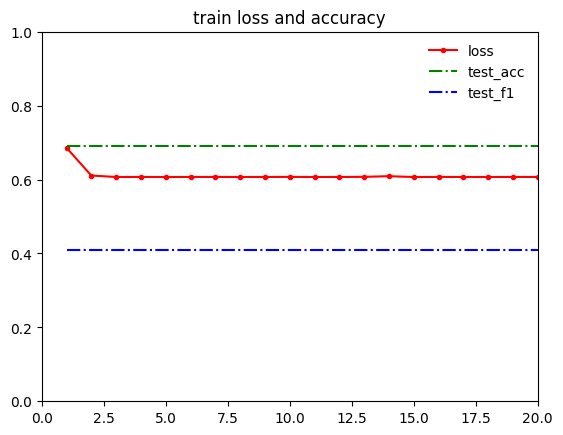

In [31]:
fig = plt.figure()
plt.title('train loss and accuracy')
epochs = np.arange(1, num_epochs + 1)
plt.axis([0, num_epochs, 0, 1])
# losses, test_accuracy, test_f1
plt.plot(epochs, losses, 'r.-', label='loss')
# plt.plot(epochs, train_accuracy, 'g-.', label='train_acc')
plt.plot(epochs, test_accuracy, 'g-.', label='test_acc')
plt.plot(epochs, test_f1, 'b-.', label='test_f1')
plt.legend(loc='best', frameon=False)
plt.show()

In [33]:
result = pd.DataFrame({"train_acc": train_accuracy,
                       "train_f1": train_f1,
                      "test_acc": test_accuracy,
                      "test_f1": test_f1})
result.to_excel(file_path + 'output/2layerfa.xlsx')

In [34]:
torch.save(net.state_dict(), file_path + 'output/2layer_state_dict.pth')

## 2 层 Baseline, 20 epochs

In [44]:
# 以‘微调’的模式进行训练
# activation function: nn.ReLU()
# 9,613,826 total parameters.
loss = nn.CrossEntropyLoss(reduction='none')
# 为不同层赋予不同的学习率
forward_params = [
    param for name, param in basenet.named_parameters()
    if name != "embedding.weight"]
trainer = torch.optim.Adam(forward_params, lr=lr)
basenet.to(device)

num_batches = len(train_iter)
losses, train_accuracy, test_accuracy = [], [], []
train_f1, test_f1 = [], []
total_start = time.time()
for epoch in range(num_epochs):
    train_loss = 0
    start_time = time.perf_counter()
    basenet.train()
    for index, data in tqdm(enumerate(train_iter), total=num_batches, leave=True):
        (tokens, valid_len), y = data
        tokens, valid_len = [v.to(device) for v in (tokens, valid_len)]
        y = y.to(device)
        l = loss(basenet(tokens, valid_len), y)
        trainer.zero_grad()
        l.sum().backward()
        trainer.step()
        train_loss += l.sum().cpu().detach().numpy() / batch_size
        # train_acc += d2l.accuracy(net(X, valid_len), y) / batch_size
    epochloss = train_loss / num_batches
    epochtrainacc, epochtrainf1 =evaluate_accuracy_f1(basenet, train_iter)
    epochtestacc, epochtestf1 = evaluate_accuracy_f1(basenet, valid_iter)
    end_time = time.perf_counter()
    print(f'epoch {epoch + 1}, loss {epochloss:.3f}, train_acc {epochtrainacc:.3f}, '
        f'train_f1 {epochtrainf1:.3f}, test_acc {epochtestacc:.3f}, '
        f'test_f1 {epochtestf1:.3f}, taking {round(end_time - start_time)} seconds')
    losses.append(epochloss)
    train_accuracy.append(epochtrainacc)
    train_f1.append(epochtrainf1)
    test_accuracy.append(epochtestacc)
    test_f1.append(epochtestf1)
total_timecost = round(time.time() - total_start)
print('Training is finished.')
print(f'训练损失:{losses[-1]:.3f}, 训练集准确率:{train_accuracy[-1]:.3f}, '
      f'训练集f1:{train_f1[-1]:.3f}, 测试集准确率:{test_accuracy[-1]:.3f}, '
     f'测试集f1:{test_f1[-1]:.3f}, 在设备{device}上训练{num_epochs}周期, 耗时{total_timecost} s')

100%|██████████| 535/535 [00:03<00:00, 170.97it/s]


epoch 1, loss 0.668, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 4 seconds


100%|██████████| 535/535 [00:02<00:00, 178.70it/s]


epoch 2, loss 0.611, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 4 seconds


100%|██████████| 535/535 [00:03<00:00, 176.67it/s]


epoch 3, loss 0.608, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 4 seconds


100%|██████████| 535/535 [00:02<00:00, 181.00it/s]


epoch 4, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 4 seconds


100%|██████████| 535/535 [00:03<00:00, 169.37it/s]


epoch 5, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 4 seconds


100%|██████████| 535/535 [00:02<00:00, 182.50it/s]


epoch 6, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 4 seconds


100%|██████████| 535/535 [00:03<00:00, 173.33it/s]


epoch 7, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 4 seconds


100%|██████████| 535/535 [00:02<00:00, 183.04it/s]


epoch 8, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 4 seconds


100%|██████████| 535/535 [00:02<00:00, 182.52it/s]


epoch 9, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 4 seconds


100%|██████████| 535/535 [00:02<00:00, 180.18it/s]


epoch 10, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 4 seconds


100%|██████████| 535/535 [00:02<00:00, 179.86it/s]


epoch 11, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 4 seconds


100%|██████████| 535/535 [00:02<00:00, 181.90it/s]


epoch 12, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 4 seconds


100%|██████████| 535/535 [00:02<00:00, 183.02it/s]


epoch 13, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 4 seconds


100%|██████████| 535/535 [00:03<00:00, 175.74it/s]


epoch 14, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 4 seconds


100%|██████████| 535/535 [00:02<00:00, 179.64it/s]


epoch 15, loss 0.620, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 4 seconds


100%|██████████| 535/535 [00:03<00:00, 159.90it/s]


epoch 16, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 4 seconds


100%|██████████| 535/535 [00:03<00:00, 168.72it/s]


epoch 17, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 4 seconds


100%|██████████| 535/535 [00:03<00:00, 166.36it/s]


epoch 18, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 4 seconds


100%|██████████| 535/535 [00:03<00:00, 171.01it/s]


epoch 19, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 4 seconds


100%|██████████| 535/535 [00:03<00:00, 166.14it/s]


epoch 20, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 4 seconds
Training is finished.
训练损失:0.607, 训练集准确率:0.704, 训练集f1:0.413, 测试集准确率:0.691, 测试集f1:0.409, 在设备cuda:0上训练20周期, 耗时82 s


## 保存结果

In [45]:
print(f"训练集最佳准确率: {max(train_accuracy):.3f},\n"
    f"训练集最佳F1分数: {max(train_f1):.3f},\n"
    f"测试集最佳准确率: {max(test_accuracy):.3f},\n"
    f"测试集最佳F1分数: {max(test_f1):.3f}")

训练集最佳准确率: 0.704,
训练集最佳F1分数: 0.413,
测试集最佳准确率: 0.691,
测试集最佳F1分数: 0.409


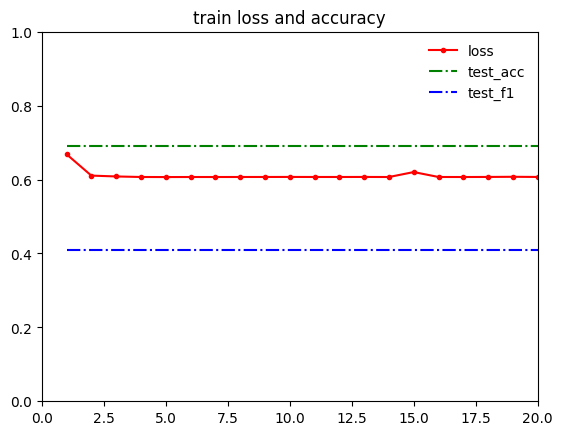

In [46]:
fig = plt.figure()
plt.title('train loss and accuracy')
epochs = np.arange(1, num_epochs + 1)
plt.axis([0, num_epochs, 0, 1])
# losses, test_accuracy, test_f1
plt.plot(epochs, losses, 'r.-', label='loss')
# plt.plot(epochs, train_accuracy, 'g-.', label='train_acc')
plt.plot(epochs, test_accuracy, 'g-.', label='test_acc')
plt.plot(epochs, test_f1, 'b-.', label='test_f1')
plt.legend(loc='best', frameon=False)
plt.show()

In [47]:
result = pd.DataFrame({"train_acc": train_accuracy,
                       "train_f1": train_f1,
                      "test_acc": test_accuracy,
                      "test_f1": test_f1})
result.to_excel(file_path + 'output/2layerba.xlsx')

In [48]:
torch.save(net.state_dict(), file_path + 'output/2layerba_state_dict.pth')

## 3 层 FAM, 20 epochs

In [55]:
# 以‘微调’的模式进行训练
# activation function: nn.ReLU()
# 11,034,560 total parameters.
loss = nn.CrossEntropyLoss(reduction='none')
# 为不同层赋予不同的学习率
forward_params = [
    param for name, param in net.named_parameters()
    if name != "embedding.weight"]
# trainer = torch.optim.Adam(
#     [{'params': net.embedding.parameters()},
#     {'params': forward_params,
#     'lr': lr * 10}], lr=lr)
trainer = torch.optim.Adam(forward_params, lr=lr)
net.to(device)

num_batches = len(train_iter)
losses, train_accuracy, test_accuracy = [], [], []
train_f1, test_f1 = [], []
total_start = time.time()
for epoch in range(num_epochs):
    train_loss = 0
    start_time = time.perf_counter()
    net.train()
    for index, data in tqdm(enumerate(train_iter), total=num_batches, leave=True):
        (tokens, valid_len), y = data
        tokens, valid_len = [v.to(device) for v in (tokens, valid_len)]
        y = y.to(device)
        l = loss(net(tokens, valid_len), y)
        trainer.zero_grad()
        l.sum().backward()
        trainer.step()
        train_loss += l.sum().cpu().detach().numpy() / batch_size
        # train_acc += d2l.accuracy(net(X, valid_len), y) / batch_size
    epochloss = train_loss / num_batches
    epochtrainacc, epochtrainf1 = evaluate_accuracy_f1(net, train_iter)
    epochtestacc, epochtestf1 = evaluate_accuracy_f1(net, valid_iter)
    end_time = time.perf_counter()
    print(f'epoch {epoch + 1}, loss {epochloss:.3f}, train_acc {epochtrainacc:.3f}, '
        f'train_f1 {epochtrainf1:.3f}, test_acc {epochtestacc:.3f}, '
        f'test_f1 {epochtestf1:.3f}, taking {round(end_time - start_time)} seconds')
    losses.append(epochloss)
    train_accuracy.append(epochtrainacc)
    train_f1.append(epochtrainf1)
    test_accuracy.append(epochtestacc)
    test_f1.append(epochtestf1)
total_timecost = round(time.time() - total_start)
print('Training is finished.')
print(f'训练损失:{losses[-1]:.3f}, 训练集准确率:{train_accuracy[-1]:.3f}, '
      f'训练集f1:{train_f1[-1]:.3f}, 测试集准确率:{test_accuracy[-1]:.3f}, '
     f'测试集f1:{test_f1[-1]:.3f}, 在设备{device}上训练{num_epochs}周期, 耗时{total_timecost} s')

100%|██████████| 535/535 [00:35<00:00, 15.25it/s]


epoch 1, loss 0.657, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 63 seconds


100%|██████████| 535/535 [00:35<00:00, 14.91it/s]


epoch 2, loss 0.610, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 64 seconds


100%|██████████| 535/535 [00:35<00:00, 14.94it/s]


epoch 3, loss 0.608, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 64 seconds


100%|██████████| 535/535 [00:35<00:00, 15.11it/s]


epoch 4, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 63 seconds


100%|██████████| 535/535 [00:35<00:00, 14.93it/s]


epoch 5, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 64 seconds


100%|██████████| 535/535 [00:35<00:00, 14.89it/s]


epoch 6, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 64 seconds


100%|██████████| 535/535 [00:36<00:00, 14.74it/s]


epoch 7, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 66 seconds


100%|██████████| 535/535 [00:37<00:00, 14.41it/s]


epoch 8, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 66 seconds


100%|██████████| 535/535 [00:35<00:00, 15.02it/s]


epoch 9, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 64 seconds


100%|██████████| 535/535 [00:35<00:00, 15.00it/s]


epoch 10, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 64 seconds


100%|██████████| 535/535 [00:35<00:00, 14.95it/s]


epoch 11, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 64 seconds


100%|██████████| 535/535 [00:34<00:00, 15.30it/s]


epoch 12, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 63 seconds


100%|██████████| 535/535 [00:35<00:00, 15.27it/s]


epoch 13, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 63 seconds


100%|██████████| 535/535 [00:35<00:00, 15.19it/s]


epoch 14, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 64 seconds


100%|██████████| 535/535 [00:36<00:00, 14.83it/s]


epoch 15, loss 0.610, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 64 seconds


100%|██████████| 535/535 [00:35<00:00, 15.25it/s]


epoch 16, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 63 seconds


100%|██████████| 535/535 [00:35<00:00, 15.00it/s]


epoch 17, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 64 seconds


100%|██████████| 535/535 [00:35<00:00, 15.01it/s]


epoch 18, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 64 seconds


100%|██████████| 535/535 [00:35<00:00, 15.02it/s]


epoch 19, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 64 seconds


100%|██████████| 535/535 [00:35<00:00, 15.05it/s]


epoch 20, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 64 seconds
Training is finished.
训练损失:0.607, 训练集准确率:0.704, 训练集f1:0.413, 测试集准确率:0.691, 测试集f1:0.409, 在设备cuda:0上训练20周期, 耗时1279 s


## 保存结果

In [56]:
print(f"训练集最佳准确率: {max(train_accuracy):.3f},\n"
    f"训练集最佳F1分数: {max(train_f1):.3f},\n"
    f"测试集最佳准确率: {max(test_accuracy):.3f},\n"
    f"测试集最佳F1分数: {max(test_f1):.3f}")

训练集最佳准确率: 0.704,
训练集最佳F1分数: 0.413,
测试集最佳准确率: 0.691,
测试集最佳F1分数: 0.409


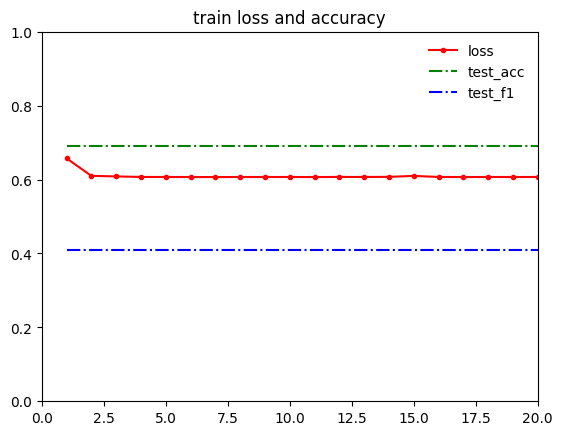

In [57]:
fig = plt.figure()
plt.title('train loss and accuracy')
epochs = np.arange(1, num_epochs + 1)
plt.axis([0, num_epochs, 0, 1])
# losses, test_accuracy, test_f1
plt.plot(epochs, losses, 'r.-', label='loss')
# plt.plot(epochs, train_accuracy, 'g-.', label='train_acc')
plt.plot(epochs, test_accuracy, 'g-.', label='test_acc')
plt.plot(epochs, test_f1, 'b-.', label='test_f1')
plt.legend(loc='best', frameon=False)
plt.show()

In [58]:
result = pd.DataFrame({"train_acc": train_accuracy,
                       "train_f1": train_f1,
                      "test_acc": test_accuracy,
                      "test_f1": test_f1})
result.to_excel(file_path + 'output/3layerfa.xlsx')

In [59]:
torch.save(net.state_dict(), file_path + 'output/3layer_state_dict.pth')

## 3 层 Baseline, 20 epochs

In [64]:
# 以‘微调’的模式进行训练
# activation function: nn.ReLU()
# 12,764,162 total parameters.
loss = nn.CrossEntropyLoss(reduction='none')
# 为不同层赋予不同的学习率
forward_params = [
    param for name, param in basenet.named_parameters()
    if name != "embedding.weight"]
trainer = torch.optim.Adam(forward_params, lr=lr)
basenet.to(device)

num_batches = len(train_iter)
losses, train_accuracy, test_accuracy = [], [], []
train_f1, test_f1 = [], []
total_start = time.time()
for epoch in range(num_epochs):
    train_loss = 0
    start_time = time.perf_counter()
    basenet.train()
    for index, data in tqdm(enumerate(train_iter), total=num_batches, leave=True):
        (tokens, valid_len), y = data
        tokens, valid_len = [v.to(device) for v in (tokens, valid_len)]
        y = y.to(device)
        l = loss(basenet(tokens, valid_len), y)
        trainer.zero_grad()
        l.sum().backward()
        trainer.step()
        train_loss += l.sum().cpu().detach().numpy() / batch_size
        # train_acc += d2l.accuracy(net(X, valid_len), y) / batch_size
    epochloss = train_loss / num_batches
    epochtrainacc, epochtrainf1 =evaluate_accuracy_f1(basenet, train_iter)
    epochtestacc, epochtestf1 = evaluate_accuracy_f1(basenet, valid_iter)
    end_time = time.perf_counter()
    print(f'epoch {epoch + 1}, loss {epochloss:.3f}, train_acc {epochtrainacc:.3f}, '
        f'train_f1 {epochtrainf1:.3f}, test_acc {epochtestacc:.3f}, '
        f'test_f1 {epochtestf1:.3f}, taking {round(end_time - start_time)} seconds')
    losses.append(epochloss)
    train_accuracy.append(epochtrainacc)
    train_f1.append(epochtrainf1)
    test_accuracy.append(epochtestacc)
    test_f1.append(epochtestf1)
total_timecost = round(time.time() - total_start)
print('Training is finished.')
print(f'训练损失:{losses[-1]:.3f}, 训练集准确率:{train_accuracy[-1]:.3f}, '
      f'训练集f1:{train_f1[-1]:.3f}, 测试集准确率:{test_accuracy[-1]:.3f}, '
     f'测试集f1:{test_f1[-1]:.3f}, 在设备{device}上训练{num_epochs}周期, 耗时{total_timecost} s')

100%|██████████| 535/535 [00:04<00:00, 118.67it/s]


epoch 1, loss 0.688, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 6 seconds


100%|██████████| 535/535 [00:04<00:00, 123.15it/s]


epoch 2, loss 0.611, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 6 seconds


100%|██████████| 535/535 [00:04<00:00, 124.23it/s]


epoch 3, loss 0.608, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 6 seconds


100%|██████████| 535/535 [00:04<00:00, 120.81it/s]


epoch 4, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 6 seconds


100%|██████████| 535/535 [00:04<00:00, 120.55it/s]


epoch 5, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 6 seconds


100%|██████████| 535/535 [00:04<00:00, 122.54it/s]


epoch 6, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 6 seconds


100%|██████████| 535/535 [00:04<00:00, 129.51it/s]


epoch 7, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 6 seconds


100%|██████████| 535/535 [00:04<00:00, 133.00it/s]


epoch 8, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 5 seconds


100%|██████████| 535/535 [00:03<00:00, 134.56it/s]


epoch 9, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 5 seconds


100%|██████████| 535/535 [00:04<00:00, 131.74it/s]


epoch 10, loss 0.608, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 6 seconds


100%|██████████| 535/535 [00:03<00:00, 135.23it/s]


epoch 11, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 5 seconds


100%|██████████| 535/535 [00:04<00:00, 119.88it/s]


epoch 12, loss 0.608, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 6 seconds


100%|██████████| 535/535 [00:04<00:00, 120.09it/s]


epoch 13, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 6 seconds


100%|██████████| 535/535 [00:04<00:00, 125.87it/s]


epoch 14, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 6 seconds


100%|██████████| 535/535 [00:04<00:00, 117.53it/s]


epoch 15, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 6 seconds


100%|██████████| 535/535 [00:04<00:00, 123.69it/s]


epoch 16, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 6 seconds


100%|██████████| 535/535 [00:04<00:00, 125.54it/s]


epoch 17, loss 0.608, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 6 seconds


100%|██████████| 535/535 [00:04<00:00, 123.95it/s]


epoch 18, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 6 seconds


100%|██████████| 535/535 [00:04<00:00, 122.70it/s]


epoch 19, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 6 seconds


100%|██████████| 535/535 [00:04<00:00, 124.91it/s]


epoch 20, loss 0.607, train_acc 0.704, train_f1 0.413, test_acc 0.691, test_f1 0.409, taking 6 seconds
Training is finished.
训练损失:0.607, 训练集准确率:0.704, 训练集f1:0.413, 测试集准确率:0.691, 测试集f1:0.409, 在设备cuda:0上训练20周期, 耗时115 s


## 保存结果

In [65]:
print(f"训练集最佳准确率: {max(train_accuracy):.3f},\n"
    f"训练集最佳F1分数: {max(train_f1):.3f},\n"
    f"测试集最佳准确率: {max(test_accuracy):.3f},\n"
    f"测试集最佳F1分数: {max(test_f1):.3f}")

训练集最佳准确率: 0.704,
训练集最佳F1分数: 0.413,
测试集最佳准确率: 0.691,
测试集最佳F1分数: 0.409


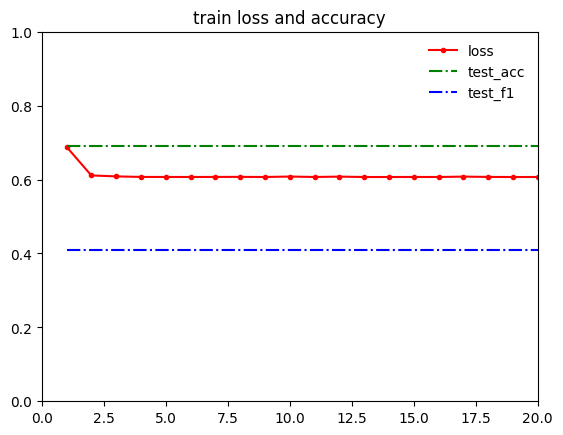

In [66]:
fig = plt.figure()
plt.title('train loss and accuracy')
epochs = np.arange(1, num_epochs + 1)
plt.axis([0, num_epochs, 0, 1])
# losses, test_accuracy, test_f1
plt.plot(epochs, losses, 'r.-', label='loss')
# plt.plot(epochs, train_accuracy, 'g-.', label='train_acc')
plt.plot(epochs, test_accuracy, 'g-.', label='test_acc')
plt.plot(epochs, test_f1, 'b-.', label='test_f1')
plt.legend(loc='best', frameon=False)
plt.show()

In [67]:
result = pd.DataFrame({"train_acc": train_accuracy,
                       "train_f1": train_f1,
                      "test_acc": test_accuracy,
                      "test_f1": test_f1})
result.to_excel(file_path + 'output/3layerba.xlsx')

In [68]:
torch.save(net.state_dict(), file_path + 'output/3layerba_state_dict.pth')

# 结尾